# Optimalizace až na cost

Naučíme se optimalizovat funkce. Začneme od čisté implementace v Pythonu, zkusíme vyřešit problém v NumPy. Poté si ukážeme, jak postupně přejít k jazykům nižší úrovně, jako je Fortran nebo C, a také si představíme balík Numba.
<!-- TEASER_END -->

In [1]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np

## Základní koncepce optimalizace

Už víme, že Python je jazyk, ve kterém jde velice efektivně programovat. A díky balíkům, jako jsou NumPy, SciPy nebo SymPy jde velice rychle řešit různé vědecké úlohy. Je pochopitelné, že s takovouto mírou abstrakce může být výsledný program pomalejší, než kdyby byl dobře napsán v nějakém kompilovaném jazyce typu C/C++ nebo Fortran. Musíme si ovšem uvědomit, že efektivita programu se měří v *celkovém čase stráveném na vývoji a běhu programu* (pro daný soubor úloh). Schématicky můžeme znázornit závislost rychlosti běhu programu v závislosti na délce vývoje asi takto:

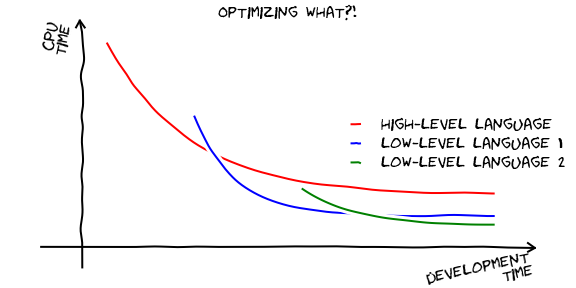

In [2]:
Image(filename='optimizing-what.png')

Všimněte si například, že typicky existuje nějaký offset ve vývojovém čase, tj. trvá nám déle v nízkoúrovňovém jazyce, než vůbec dostaneme první výsledek. Potřeba optimalizace tedy *silně závisí na objemu výpočtů, které budeme s daným programem řešit*.

Toto ovšem *neznamená, že pokud je objem velký, máme hned začít programovat v C nebo Fortranu*. Za chvíli si ukážeme, jak optimalizaci řešit chytřeji a postupně. Empirické pravidlo říká, že 90 % výpočetního času zabere 10 % zdrojového kódu. Jedná se o konkrétní příklad obecného [Paretova 80 / 20 principu](https://cs.wikipedia.org/wiki/Paret%C5%AFv_princip). Je tedy vhodné nejprve těchto 10 % najít a poté je teprve začít optimalizovat. Python nám k tomuto účelu poskytuje velice mocné nástroje.

## Profilování

Profilování je nástroj, který nám umožní najít kritická místa v našem programu, oněch 10 %, které stojí za to optimalizovat. Zkusme si to ukázat na jednoduchém příkladu.

In [3]:
def heavy_calc(X):
    Y = X.copy()
    for i in range(10):
        Y = Y**i
    return Y

def heavy_loop(inputs):
    res = []
    for X in inputs:
        res.append(heavy_calc(X))
    return res

def code_setup():
    from numpy.random import rand
    N = 20
    M = 1000
    print("Will generate {} random arrays".format(N))
    inputs = [rand(M, M) for n in range(N)]
    print("Will calculate now")
    result = heavy_loop(inputs)
    print("Finished calculation")

Python obsahuje dva základní mofuly pro profilování - `profile` a `cProfile`, z nichž ten druhý je rychlejší. Pomocí funkce `run` pustíme výpočet pod dohledem cProfile, výsledky uložíme do souboru.

In [4]:
import cProfile
cProfile.run('code_setup()', 'pstats')

Will generate 20 random arrays
Will calculate now
Finished calculation


Dále budeme potřebovat modul `pstats`, který nám umožní s výsledky pracovat. Použije k tomu třídu `Stats`.

In [5]:
from pstats import Stats
p = Stats('pstats')

`print_stats` nám zobrazí prvních n záznamů.

In [6]:
p.print_stats(10)

Sun Jan 19 13:23:06 2025    pstats

         3892 function calls (3755 primitive calls) in 0.537 seconds

   Random listing order was used
   List reduced from 378 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       13    0.000    0.000    0.000    0.000 /Users/kuba/workspace/fjfi/python-fjfi/.venv/lib/python3.12/site-packages/_distutils_hack/__init__.py:101(find_spec)
       25    0.000    0.000    0.000    0.000 /Users/kuba/.local/share/uv/python/cpython-3.12.5-macos-aarch64-none/lib/python3.12/enum.py:1551(__or__)
       17    0.000    0.000    0.000    0.000 /Users/kuba/.local/share/uv/python/cpython-3.12.5-macos-aarch64-none/lib/python3.12/enum.py:1562(__and__)
        3    0.000    0.000    0.000    0.000 /Users/kuba/.local/share/uv/python/cpython-3.12.5-macos-aarch64-none/lib/python3.12/threading.py:1155(_wait_for_tstate_lock)
      126    0.000    0.000    0.000    0.000 /Users/kuba/.local/share/uv/python/cpython-3.12.5-

Ty jsou ovšem nesetříděné. Následující výstup už je užitečnější, záznamy jsou totiž setříděné podle celkového času stráveného v dané funkci. Navíc `strip_dirs` odstraní adresáře ze jmen funkcí.

In [7]:
p.strip_dirs().sort_stats('cumulative').print_stats(10)

Sun Jan 19 13:23:06 2025    pstats

         3892 function calls (3755 primitive calls) in 0.537 seconds

   Ordered by: cumulative time
   List reduced from 378 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.079    0.010    0.762    0.095 base_events.py:1909(_run_once)
      4/1    0.000    0.000    0.530    0.530 {built-in method builtins.exec}
       20    0.416    0.021    0.431    0.022 2469674079.py:1(heavy_calc)
        1    0.000    0.000    0.320    0.320 2469674079.py:13(code_setup)
        1    0.000    0.000    0.320    0.320 2469674079.py:7(heavy_loop)
       20    0.015    0.001    0.015    0.001 {method 'copy' of 'numpy.ndarray' objects}
     13/1    0.000    0.000    0.014    0.014 <frozen importlib._bootstrap>:1349(_find_and_load)
     13/1    0.000    0.000    0.014    0.014 <frozen importlib._bootstrap>:1304(_find_and_load_unlocked)
     12/1    0.000    0.000    0.014    0.014 <frozen importlib._

Takto vypadá výstup setříděný pomocí nekumulovaného času.

In [8]:
p.sort_stats('time').print_stats(10)

Sun Jan 19 13:23:06 2025    pstats

         3892 function calls (3755 primitive calls) in 0.537 seconds

   Ordered by: internal time
   List reduced from 378 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       20    0.416    0.021    0.431    0.022 2469674079.py:1(heavy_calc)
        8    0.079    0.010    0.762    0.095 base_events.py:1909(_run_once)
       20    0.015    0.001    0.015    0.001 {method 'copy' of 'numpy.ndarray' objects}
      7/0    0.011    0.002    0.000          {method 'control' of 'select.kqueue' objects}
        9    0.007    0.001    0.007    0.001 {built-in method _imp.create_dynamic}
      9/6    0.002    0.000    0.006    0.001 {built-in method _imp.exec_dynamic}
     35/2    0.001    0.000    0.012    0.006 <frozen importlib._bootstrap>:480(_call_with_frames_removed)
      9/8    0.001    0.000    0.002    0.000 events.py:86(_run)
       36    0.001    0.000    0.001    0.000 {built-in method posi

Jupyter nám může usnadnit práci pomocí `%prun` a `%%prun`. Např.

In [9]:
%prun -s cumulative -l 10 code_setup()

Will generate 20 random arrays
Will calculate now
Finished calculation
 

         2184 function calls (2126 primitive calls) in 0.755 seconds

   Ordered by: cumulative time
   List reduced from 219 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.589    0.589 {built-in method builtins.exec}
        1    0.016    0.016    0.589    0.589 <string>:1(<module>)
       20    0.507    0.025    0.520    0.026 2469674079.py:1(heavy_calc)
    14/13    0.009    0.001    0.375    0.029 base_events.py:1909(_run_once)
        1    0.000    0.000    0.363    0.363 2469674079.py:13(code_setup)
        1    0.000    0.000    0.363    0.363 2469674079.py:7(heavy_loop)
       20    0.016    0.001    0.016    0.001 {method 'copy' of 'numpy.ndarray' objects}
    15/13    0.000    0.000    0.003    0.000 {method 'run' of '_contextvars.Context' objects}
        7    0.000    0.000    0.002    0.000 zmqstream.py:583(_handle_events)
        5    0.000    0.000    0.002    0.000 asyncio.py:200(_h

Z obou výstupů celkem jasně vydíme, že naprostou většinu času trávíme ve funkci `heavy_calc`. Pokud se tedy chceme pustit do optimalizace, musíme se zaměřit právě na tuto část našeho programu.

Výsledky můžete navíc spojit s nástroji pro vizualizaci, např.[SnakeViz](http://jiffyclub.github.io/snakeviz/) nebo [vprof](https://github.com/nvdv/vprof), popř. pokročilý editor jako [PyCharm](https://www.jetbrains.com/pycharm/).

## Vzorová úloha - vzdálenost množiny bodů ve vícerozměrném prostoru

(Tento příklad byl převzat z http://jakevdp.github.io/blog/2013/06/15/numba-vs-cython-take-2.)

Zadání je jednoduché: pro M bodů v N rozměrném prostoru spočítejte vzájemnou vzdálenost $d$, která je pro dva body $x,y$ definovaná jako $\sqrt {\sum_{i=1}^N {{{\left( {{x_i} - {y_i}} \right)}^2}} } $. Výslekem je tedy (symetrická) matice $M\times M$.

In [10]:
# toto nechť jsou naše vstupní data
M = 1000
N = 3
X = np.random.random((M, N))

### Implementace v čistém Pythonu
Nemůžeme asi očekávat, že toto bude nejrychlejší a nejsnadnější verze našeho programu. Přesto stojí za to ji vyzkoušet, navíc ji budeme ještě potřebovat.

In [11]:
def pairwise_python(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

Tahle funkce nám bude pomáhat ukládat výsledné časy z `%timeit`.

Do `pairwise_times` si uložíme výsledné časy.

In [12]:
pairwise_times = {}

In [13]:
timings = %timeit -o pairwise_python(X)
pairwise_times['plain_python'] = timings

1.13 s ± 68.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### To samé pomocí NumPy
V případě NumPy můžeme v tomto případě využít broadcasting. Celá funkce tak zabere jeden rádek.

In [14]:
def pairwise_numpy(X):
    return np.sqrt(((X[:, np.newaxis, :] - X) ** 2).sum(-1))

Zkusíme, jestli výsledky jsou stejné pomocí `assert` a `numpy.allclose`.

In [15]:
assert np.allclose(pairwise_numpy(X), pairwise_python(X), rtol=1e-10, atol=1e-15)

Výsledky jsou stejné až na velmi malé rozdíly - to je nebezpečí numerických výpočtů s konečnou přesností.

In [16]:
timings = %timeit -o pairwise_numpy(X)
pairwise_times['numpy'] = timings

18.3 ms ± 221 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Vidíme, že jsme zkrátili běh programu více než 100-krát. To není špatné, navíc je implementace daleko jednodušší.

### Přichází Cython

[Cython](https://cython.org/) je nástroj, který z Python programu, obohaceného o nějaké Cython direktivy, vytvoří program v C (případně C++), který je možné zkompilovat a okamžitě použít jako modul v Pythonu. Typickým příkladem Cython direktiv jsou statické typy. Cython samozřejmě umožňuje používat funkce z binárních knihoven s C rozhraním.

Zkusíme optimalizovat naší funkci `pairwise_python`.

* Cython zdroják má koncovku .pyx (za začátku byl Pyrex).
* Cython dokáže přeložit jakýkoli Python. Výsledkem je ale minimální (nebo spíš žádná) optimalizace.
* `cimport` je analogie `import`, pracuje ale s Cython definicemi funkcí (.pxd soubory).
* Cython dodává `numpy.pyx`, obsahující dodatečné informace pro kompilace NumPy modulů. Proto voláme `cimport numpy`.
* Podobně `libc` je speciální modul Cythonu.

* Funkce se deklarují (moho deklarovat) se statickými typy vstupních parametrů. My použijeme `np.ndarray[np.float64_t, ndim=2]`.
* Proměnné se deklarují pomocí `cdef`.


In [17]:
# Odkomentujte pro instalaci Cythonu
# !pip install cython

In [18]:
%%file cyfuncs.pyx

language_level = "3str"

import numpy as np
# numpy pro Cython
cimport numpy as np
from libc.math cimport sqrt

# tohle je čistý Python
def pairwise0(X):
    M = X.shape[0]
    N = X.shape[1]
    D = np.empty((M, M), dtype=float)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D

# tady už začínáme optimalizovat, změny ale nejsou drastické
def pairwise1(np.ndarray[np.float64_t, ndim=2] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef np.ndarray D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return D

Overwriting cyfuncs.pyx


In [19]:
%%file setup.py

from distutils.core import setup
from Cython.Build import cythonize
import numpy

setup(
  name='cyfuncs',
  include_dirs=[numpy.get_include()],
  ext_modules=cythonize("cyfuncs.pyx"),
)

Overwriting setup.py


In [20]:
!python setup.py build_ext --inplace

Compiling cyfuncs.pyx because it changed.
[1/1] Cythonizing cyfuncs.pyx
/Users/kuba/workspace/fjfi/python-fjfi/.venv/lib/python3.12/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/kuba/workspace/fjfi/python-fjfi/numerical_python_course/lecture_notes.cz/cyfuncs.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from cyfuncs.c:1240:
In file included from /Users/kuba/workspace/fjfi/python-fjfi/.venv/lib/python3.12/site-packages/numpy/_core/include/numpy/arrayobject.h:5:
In file included from /Users/kuba/workspace/fjfi/python-fjfi/.venv/lib/python3.12/site-packages/numpy/_core/include/numpy/ndarrayobject.h:12:
In file included from /Users/kuba/workspace/fjfi/python-fjfi/.venv/lib/python3.12/site-packages/numpy/_core/include/numpy/ndarraytypes.h:1909:
/Users/kuba/workspace/fjfi/python-fjfi/.venv/lib/python3.12/site-packages/numpy/_core/i

Jak jsme již říkali, Cython vytvoří C zdroják, který se pak kompiluje pomocí běžného překladače (např. gcc). Pojďme se na tento soubor podívat.

In [21]:
from IPython.display import FileLink
FileLink('cyfuncs.c')

/Users/kuba/workspace/fjfi/python-fjfi/numerical_python_course/lecture_notes.cz/cyfuncs.c

Ten soubor je dlouhý ... Obsahuje spoustu Python "balastu", na kterém vidíme, jak je vlastně samotný CPython naprogramován. Naštěstí tento soubor obsahuje i komentáře, které říkají, které řádce daný blok odpovídá. Např.

     /* "cyfuncs.pyx":16
      *                 tmp = X[i, k] - X[j, k]
      *                 d += tmp * tmp
      *             D[i, j] = np.sqrt(d)             # <<<<<<<<<<<<<<
      *     return D
      * 
      */


In [22]:
import cyfuncs

In [23]:
print("cyfuncs obsahuje: " + ", ".join((d for d in dir(cyfuncs) if not d.startswith("_"))))

cyfuncs obsahuje: language_level, np, pairwise0, pairwise1


Podívejme se, jestli dostávám stále stejné výsledky.

In [24]:
assert np.allclose(pairwise_numpy(X), cyfuncs.pairwise1(X), rtol=1e-10, atol=1e-15)

No a jak jsme na tom s časem?

In [25]:
timings = %timeit -o cyfuncs.pairwise0(X)
pairwise_times['cython0'] = timings

1.13 s ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
timings = %timeit -o cyfuncs.pairwise1(X)
pairwise_times['cython1'] = timings

79.6 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### IPython `%%cython` magic

IPython, tak jako v mnoha jiných případech, nám práci s Cythonem usnadňuje pomocí triku `%%cython`. Zkusíme ho použít. Zároveň zkusíme ještě více náš kód optimalizovat, zatím je totiž pomalejší než numpy.

In [27]:
%load_ext Cython

In [28]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython
from libc.math cimport sqrt

@cython.boundscheck(False)
@cython.wraparound(False)
def pairwise_cython(double[:, ::1] X):
    cdef int M = X.shape[0]
    cdef int N = X.shape[1]
    cdef double tmp, d
    cdef double[:, ::1] D = np.empty((M, M), dtype=np.float64)
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = sqrt(d)
    return np.asarray(D)

In [29]:
assert np.allclose(pairwise_numpy(X), pairwise_cython(X), rtol=1e-10, atol=1e-15)

In [30]:
timings = %timeit -o pairwise_cython(X)
pairwise_times['cython2'] = timings

1.98 ms ± 40.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Tohle je už konečně výrazné zrychlení oproti NumPy.

#### Cython toho nabízí mnoho
Podívejte se na http://docs.cython.org co všechno Cython nabízí -- není toho málo, např.

* použití C++
* šablony (templates)
* OpenMP (k tomu se možná ještě dostaneme)
* vytváření C-API
* třídy (cdef classes)

### Z Fortranu (nebo C) do Pythonu pomocí F2PY

F2PY je nástroj, který byl v podstatě vytvořen pro NumPy a SciPy, protože, jak dobře víme, tyto moduly volají externí knihovny napsané ve Fortrane nebo C. Dokumentaci (trochu zastaralou) najdeme [zde](http://cens.ioc.ee/projects/f2py2e/usersguide/index.html). Bylo tedy velice výhodné vytvořit nástroj, který toto usnadní. A tak se zrodilo F2PY. Ve zkratce, F2PY umožňuje velice jednoduše z Fortran nebo C funkcí vytvořit Python modul. Využívá navíc vlastností NumPy pro předávání vícerozměnrých polí. 

Poďme chvilku programovat ve Fortranu :)

In [31]:
%%file pairwise_fort.f90

subroutine pairwise_fort(X, D, m, n)
    integer :: n,m
    double precision, intent(in) :: X(m, n)
    double precision, intent(out) :: D(m, m)
    integer :: i, j, k
    double precision :: r

    do j = 1,m
        do i = 1,m
            r = 0
            do k = 1,n
                r = r + (X(i,k) - X(j,k)) * (X(i,k) - X(j,k))
            end do
            D(i,j) = sqrt(r)
        end do
    end do
end subroutine pairwise_fort

Overwriting pairwise_fort.f90


Z čeho f2py bere informace o vytvoření modulu?

1. Pole (double precision) převádí na numpy array.
2. `intent(in)` = vstupní argument.
3. `intent(out)` = výstupní argument.
4. f2py schová explicitně zadané rozměry polí (m, n).

Pokud bychom programovali v C, je potřeba dodat f2py nějaké informace navíc, neboť např. intent v C neexistuje. 

Tento soubor přeložíme pomocí `f2py`:

In [32]:
!f2py -c pairwise_fort.f90 -m pairwise_fort

Cannot use distutils backend with Python>=3.12, using meson backend instead.
Using meson backend
Will pass --lower to f2py
See https://numpy.org/doc/stable/f2py/buildtools/meson.html
Reading fortran codes...
	Reading file 'pairwise_fort.f90' (format:free)
Post-processing...
	Block: pairwise_fort
			Block: pairwise_fort
Applying post-processing hooks...
  character_backward_compatibility_hook
Post-processing (stage 2)...
Building modules...
    Building module "pairwise_fort"...
    Generating possibly empty wrappers"
    Maybe empty "pairwise_fort-f2pywrappers.f"
        Constructing wrapper function "pairwise_fort"...
          d = pairwise_fort(x,[m,n])
    Wrote C/API module "pairwise_fort" to file "./pairwise_fortmodule.c"
The Meson build system
Version: 1.6.1
Source dir: /private/var/folders/dm/gbbql3p121z0tr22r2z98vy00000gn/T/tmp5ugidbi4
Build dir: /private/var/folders/dm/gbbql3p121z0tr22r2z98vy00000gn/T/tmp5ugidbi4/bbdir
Build type: native build
Project name: pairwise_fort
Proje

`-m pairwise_fort` je požadované jméno modulu. Můžeme ho rovnou importovat, resp. jeho stejnojmennou funkci.

In [33]:
from pairwise_fort import pairwise_fort
print(pairwise_fort.__doc__)

d = pairwise_fort(x,[m,n])

Wrapper for ``pairwise_fort``.

Parameters
----------
x : input rank-2 array('d') with bounds (m,n)

Other Parameters
----------------
m : input int, optional
    Default: shape(x, 0)
n : input int, optional
    Default: shape(x, 1)

Returns
-------
d : rank-2 array('d') with bounds (m,m)



Fortran a C používají jiné uspořádání paměti pro ukládání vícerozměrných polí. Fortran je "column-major" zatímco C je "row-major". NumPy dokáže pracovat s obojím a pro uživatele je to obvykle jedno. Pokud ovšem chceme předat vícerozměrné pole do Fortran funkce, je lepší mít prvky uložené v paměti jako to dělá Fortran. V takovém případě totiž f2py předá pouze referenci (ukazatel) na dané místo v paměti. V opačném případě f2py nejprve pole musí transponovat, tj. *vytvořit kopii* s jiným uspořádáním, což může být samozřejmě náročné na pamět a procesor.

Vytvoříme si proměnnou XF, která má Fortran uspořádání, pomocí `numpy.asfortranarray` (prozaický název :)

In [34]:
XF = np.asfortranarray(X)

Vyzkoušíme, jestli stále dostáváme stejné výsledky.

In [35]:
assert np.allclose(pairwise_numpy(X), pairwise_fort(X), rtol=1e-10, atol=1e-15)

No a konečně se můžeme podívat, jak je to s rychlostí ...

In [36]:
timings = %timeit -o pairwise_fort(X)
pairwise_times['fortran'] = timings

2.43 ms ± 251 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Představuje se `numba`

Numba kompiluje Python kód pomocí [LLVM](http://llvm.org/). Podporujme just-in-time kompilaci pomocí dekorátoru `jit` (http://numba.pydata.org/numba-doc/latest/user/jit.html).

```
@numba.jit(
    signature=None, 
    nopython=False, 
    nogil=False, 
    cache=False, 
    forceobj=False, 
    parallel=False, 
    error_model='python', 
    fastmath=False, locals={}
)
```

In [37]:
# Odkomentujte pro instalaci balíku Numba
# !pip install numba

In [38]:
import numba

In [39]:
pairwise_numba = numba.jit(pairwise_python)

Tradiční kontrola. Po prvním spuštění navíc Numba funkci poprvé zkompiluje.

In [40]:
assert np.allclose(pairwise_numpy(X), pairwise_numba(X), rtol=1e-10, atol=1e-15)

Jaký čas od takto "jednoduché" optimalizace můžeme očekávat?

In [41]:
timings = %timeit -o pairwise_numba(X)
pairwise_times['numba'] = timings

2.48 ms ± 65 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Vidíme, že zrychlení je výborné - jsme na úrovni zatím nejlepšího výsledku! A navíc že jsme toho dosáhli jediným řádkem (kromě importů).

Ještě můžeme zkusit výledek vylepšit pomocí paralelizace, `nopython` a / nebo `fastmath` režimu. Pro `nopython` musíme vytvořit výsledný numpy objekt vně kompilované funkce. Paralelizace docílíme pomocí `parallel=True` a [`numba.prange`](http://numba.pydata.org/numba-doc/latest/user/parallel.html?highlight=prange). Všimněte si použití `@jit` jako dekorátoru.

In [42]:
@numba.jit(nopython=True, parallel=True, fastmath=True)
def _pairwise_nopython(X: np.ndarray, D: np.ndarray) -> np.ndarray:
    M = X.shape[0]
    N = X.shape[1]
    for i in numba.prange(M):
        for j in numba.prange(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D[i, j] = np.sqrt(d)
    return D


def pairwise_numba_fast_parallel(X: np.ndarray) -> np.ndarray:
    D = np.empty((X.shape[0], X.shape[0]), dtype = float)
    _pairwise_nopython(X, D)
    return D

In [43]:
assert np.allclose(pairwise_numpy(X), pairwise_numba_fast_parallel(X), rtol=1e-10, atol=1e-15)

In [44]:
timings = %timeit -o pairwise_numba_fast_parallel(X)
pairwise_times['numba_fast_parallel'] = timings

711 μs ± 33.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Pojdme počítat na GPU i CPU: JAX

_JAX: High-Performance Array Computing_ poskytuje plnou paletu nastrojů pro výpočty jak na CPU, tak na GPU. 

Mezi jeho hlavní výhody patří:

* NumPy-like API - JAX podporuje většinu NumPy operací.
* JIT kompilace - JAX umožňuje, podobně jako `numba`, kompilaci funkcí pomocí `jax.jit`.
* Běží všude - stejný kód může běžet na CPU, GPU i TPU.
* Automatická diferenciace - JAX umožňuje výpočet gradientů a Hessiánů.

 

In [45]:
# Odkomentujte pro instalaci balíku JAX
# !pip install jax[cpu] jaxlib

JAX NumPy API je téměř identické s NumPy API. Jediný rozdíl je, že JAX funkce vrací vlastní datovy typ, které reprezentují pole na určitém zařízení (CPU, GPU, TPU).).
Je proto vyhodné importovat JAX jako `import jax.numpy as jnp` společně s NumPy jako `import numpy as np`.

In [47]:
import jax.numpy as jnp
import jax

V případě, že bychom měli dostupné GPU (AMD/NVIDIA), vyděli bychom jej v nasledujícím seznamu. 

In [48]:
jax.devices()

[CpuDevice(id=0)]

Pro zpřístupnění vypočtů na GPU stačí nahradit `np` za `jnp` a JAX se postará o zbytek.

In [49]:
def pairwise_jax(X):
    return jnp.sqrt(jnp.power(X[:, jnp.newaxis, :] - X, 2).sum(-1))
    #return jnp.sqrt((jnp.power(X[:, jnp.newaxis, :] - X, 2)).sum(-1))


In [50]:
assert np.allclose(pairwise_numpy(X), pairwise_jax(X), rtol=1e-10, atol=1e-15)

AssertionError: 

Ouha, co je špatně? Jelikož GPU pracuje s nižší přesností, JAX pracuje v zakladním režimu `float32` namísto `float64`.

In [51]:
pairwise_jax(X).dtype

dtype('float32')

Pro vypočty s 64-bitovou přesností je potřeba povolit `jax_enable_x64`.

In [52]:
from jax import config
config.update("jax_enable_x64", True)

In [53]:
pairwise_jax(X).dtype

dtype('float64')

In [54]:
assert np.allclose(pairwise_numpy(X), pairwise_jax(X), rtol=1e-10, atol=1e-15)

Proj JIT kompilaci stačí přidat dekorátor `jax.jit`. 

Nicméně pozor: 
* První volání funkce s JIT kompilací může byt pomalejší, než když bychom funkci volali bez kompilace.
* JIT vyžaduje znát typy a tvar (shape) vstupních parametrů v době kompilace.

In [55]:
@jax.jit
def pairwise_jax_jit(X):
    res = (jnp.sqrt((jnp.power(X[:, jnp.newaxis, :] - X, 2)))).sum(-1)
    return res


In [56]:
X_jnp = np.asarray(X, dtype=jnp.float64)

In [57]:
timings = %timeit -o pairwise_jax(X_jnp)
pairwise_times['jax'] = timings

10.7 ms ± 17 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
timings = %timeit -o pairwise_jax_jit(X_jnp)
pairwise_times['jax_jit'] = timings

663 μs ± 9.51 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Srovnání výsledků

Výsledky můžeme porovnat pomocí grafu.

In [60]:
pairwise_times

{'plain_python': <TimeitResult : 1.13 s ± 68.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 'numpy': <TimeitResult : 18.3 ms ± 221 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 'cython0': <TimeitResult : 1.13 s ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 'cython1': <TimeitResult : 79.6 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>,
 'cython2': <TimeitResult : 1.98 ms ± 40.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 'fortran': <TimeitResult : 2.43 ms ± 251 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 'numba': <TimeitResult : 2.48 ms ± 65 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 'numba_fast_parallel': <TimeitResult : 711 μs ± 33.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>,
 'jax': <TimeitResult : 10.7 ms ± 17 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)>,
 'jax_jit': <TimeitResult : 663 μs ± 9.51 μs per loop (mean ± std. dev. of 7 runs, 1,000

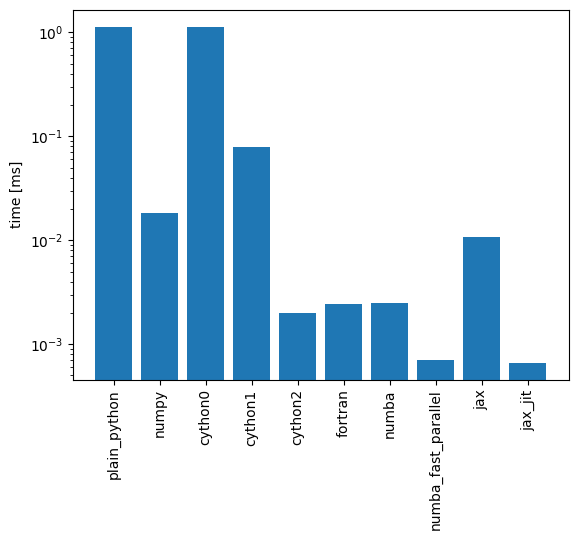

In [61]:
fig, ax = plt.subplots()
values = np.array([t.average for t in pairwise_times.values()])
x = range(len(pairwise_times))
ax.bar(x, values)
ax.set_xticks(x)
ax.set_xticklabels(tuple(pairwise_times.keys()), rotation='vertical')
ax.set_ylabel('time [ms]')
ax.set_yscale('log')

In [62]:
### Důkladnější srovnaní:
pairwise_functions = {
    'plain_python': pairwise_python,
    'numpy': pairwise_numpy,
    'cython0': cyfuncs.pairwise0,
    'cython1': cyfuncs.pairwise1,
    'cython2': pairwise_cython,
    'fortran': pairwise_fort,
    'numba': pairwise_numba,
    'numba_fast_parallel': pairwise_numba_fast_parallel,
    'jax': pairwise_jax,
    'jax_jit': pairwise_jax_jit
}

In [63]:

Ms = np.logspace(1, 3.5, 6).astype(int)
N = 3

paiwise_times_all = {}
for name, func in pairwise_functions.items():
    print(name)
    timings = []
    for M in Ms:
        X = np.random.random((M, N))
        print(M)
        # t = %timeit -o func(X)
        if "jax" in name:
            X_jnp = np.asarray(X, dtype=jnp.float64)
            # Přeskočíme první měření, protože probíha kompilace
            func(X_jnp)
            t = %timeit -o -r 2 func(X_jnp)
        else:
            t = %timeit -o -r 2 func(X)

        timings.append(t.average)

    paiwise_times_all[name] = timings


plain_python
10
111 μs ± 544 ns per loop (mean ± std. dev. of 2 runs, 10,000 loops each)
31
1.1 ms ± 45.6 μs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
100
11.4 ms ± 415 μs per loop (mean ± std. dev. of 2 runs, 100 loops each)
316
109 ms ± 658 μs per loop (mean ± std. dev. of 2 runs, 10 loops each)
1000
1.1 s ± 4.75 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
3162
11.2 s ± 51.6 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
numpy
10
3.96 μs ± 0.608 ns per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
31
19 μs ± 527 ns per loop (mean ± std. dev. of 2 runs, 100,000 loops each)
100
208 μs ± 10.8 μs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
316
1.85 ms ± 1.49 μs per loop (mean ± std. dev. of 2 runs, 1,000 loops each)
1000
20.5 ms ± 382 μs per loop (mean ± std. dev. of 2 runs, 10 loops each)
3162
199 ms ± 3.42 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
cython0
10
106 μs ± 828 ns per loop (mean ± std. dev. of 2 runs, 10,000 loops

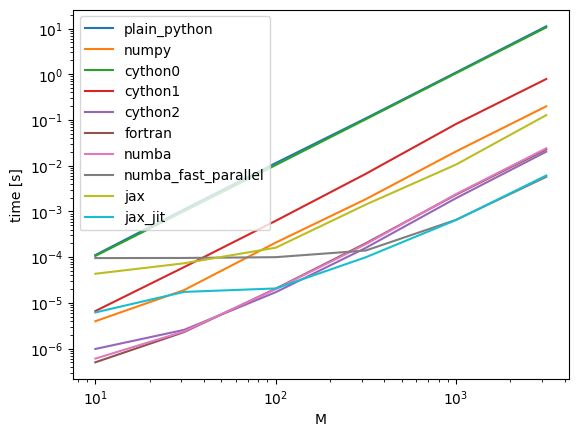

In [64]:
fig, ax = plt.subplots()

for name, times in paiwise_times_all.items():
    ax.plot(Ms, times, label=name)
    ax.set_xscale('log')
    ax.set_yscale('log')

ax.set_xlabel('M')
ax.set_ylabel('time [s]')

ax.legend()


## Další možnosti

* Vestavěný modul [`ctypes`](http://docs.python.org/2/library/ctypes.html) dovoluje volat funkce z externích dynamických knihoven. Pro použití s NumPy viz [Cookbook](http://wiki.scipy.org/Cookbook/Ctypes).
* Alternativou k ctypes je [cffi](https://pypi.org/project/cffi/).
* [CuPy](https://cupy.chainer.org/) využívá GPU.
* [numexpr](https://github.com/pydata/numexpr) dokáže kompilovat Numpy výrazy.
* [Theano](http://www.deeplearning.net/software/theano/index.html) se zaměřuje na strojové učení, také optimalizuje vektorové (maticové) operace, dovoluje je spouštět na CPU.
* [Nuitka](http://nuitka.net/) kompiluje Python, ale na rozdíl od Numba nespecializuje funkce na základě typů.
* [SWIG](http://www.swig.org/) jde použít pro propojení s mnoha jazyky.'

### Cvičení

Obdobný postup aplikujte na výpočet kumulativního součtu, který je definovaný jako

$\displaystyle
S_j = \sum\limits_{i = 1}^j x_i $

Výsledky a časování porovnejte s `numpy.cumsum`.

*Nápověda: Ve vaší funkci vytvořte nejprve výsledné numpy pole pomocí `numpy.empty_like`.*